# super() 函数

    super(CurrentClassName, instance)
    
返回该类实例对应的父类对象。

In [1]:
class Leaf(object):
    def __init__(self, color="green"):
        self.color = color
    def fall(self):
        print "Splat!"

class MapleLeaf(Leaf):
    def change_color(self):
        if self.color == "green":
            self.color = "red"
    def fall(self):
        self.change_color()
        super(MapleLeaf, self).fall()

这里，我们先改变树叶的颜色，然后再找到这个实例对应的父类，并调用父类的 `fall()` 方法：

In [2]:
mleaf = MapleLeaf()

print mleaf.color
mleaf.fall()
print mleaf.color

green
Splat!
red


回到我们的森林例子，这里我们将森林 `Forest` 作为父类，并定义一个子类 `BurnableForest`：

In [3]:
import numpy as np

class Forest(object):
    """ Forest can grow trees which eventually die."""
    def __init__(self, size=(150,150), p_sapling=0.0025):
        self.size = size
        self.trees = np.zeros(self.size, dtype=bool)
        self.p_sapling = p_sapling
        
    def __repr__(self):
        my_repr = "{}(size={})".format(self.__class__.__name__, self.size)
        return my_repr
    
    def __str__(self):
        return self.__class__.__name__
    
    @property
    def num_cells(self):
        """Number of cells available for growing trees"""
        return np.prod(self.size)
    
    @property
    def tree_fraction(self):
        """
        Fraction of trees
        """
        num_trees = self.trees.sum()
        return float(num_trees) / self.num_cells
    
    def _rand_bool(self, p):
        """
        Random boolean distributed according to p, less than p will be True
        """
        return np.random.uniform(size=self.trees.shape) < p
    
    def grow_trees(self):
        """
        Growing trees.
        """
        growth_sites = self._rand_bool(self.p_sapling)
        self.trees[growth_sites] = True    
        
    def advance_one_step(self):
        """
        Advance one step
        """
        self.grow_trees()

- 将与燃烧相关的属性都被转移到了子类中去。
- 修改两类的构造方法，将闪电概率放到子类的构造方法上，同时在子类的构造方法中，用 `super` 调用父类的构造方法。
- 修改 `advance_one_step()`，父类中只进行生长，在子类中用 `super` 调用父类的 `advance_one_step()` 方法，并添加燃烧的部分。

In [4]:
class BurnableForest(Forest):
    """
    Burnable forest support fires
    """    
    def __init__(self, p_lightning=5.0e-6, **kwargs):
        super(BurnableForest, self).__init__(**kwargs)
        self.p_lightning = p_lightning        
        self.fires = np.zeros((self.size), dtype=bool)
    
    def advance_one_step(self):
        """
        Advance one step
        """
        super(BurnableForest, self).advance_one_step()
        self.start_fires()
        self.burn_trees()
        
    @property
    def fire_fraction(self):
        """
        Fraction of fires
        """
        num_fires = self.fires.sum()
        return float(num_fires) / self.num_cells
    
    def start_fires(self):
        """
        Start of fire.
        """
        lightning_strikes = (self._rand_bool(self.p_lightning) & 
            self.trees)
        self.fires[lightning_strikes] = True
        
    def burn_trees(self):
        """
        Burn trees.
        """
        fires = np.zeros((self.size[0] + 2, self.size[1] + 2), dtype=bool)
        fires[1:-1, 1:-1] = self.fires
        north = fires[:-2, 1:-1]
        south = fires[2:, 1:-1]
        east = fires[1:-1, :-2]
        west = fires[1:-1, 2:]
        new_fires = (north | south | east | west) & self.trees
        self.trees[self.fires] = False
        self.fires = new_fires

测试父类：

In [5]:
forest = Forest()

forest.grow_trees()

print forest.tree_fraction

0.00284444444444


测试子类：

In [6]:
burnable_forest = BurnableForest()

调用自己和父类的方法：

In [7]:
burnable_forest.grow_trees()
burnable_forest.start_fires()
burnable_forest.burn_trees()
print burnable_forest.tree_fraction

0.00235555555556


查看变化：

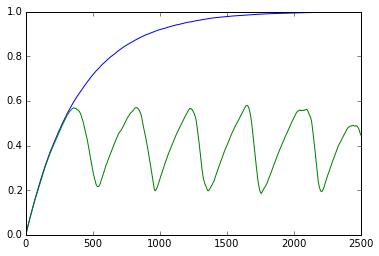

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

forest = Forest()
forest2 = BurnableForest()

tree_fractions = []

for i in range(2500):
    forest.advance_one_step()
    forest2.advance_one_step()
    tree_fractions.append((forest.tree_fraction, forest2.tree_fraction))

plt.plot(tree_fractions)

plt.show()

`__str__` 和 `__repr__` 中 `self.__class__` 会根据类型不同而不同：

In [9]:
forest

Forest(size=(150, 150))

In [10]:
forest2

BurnableForest(size=(150, 150))

In [11]:
print forest

Forest


In [12]:
print forest2

BurnableForest
